In [567]:
import os
import ummon
from ummon import *
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from scipy.spatial.distance import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
print(torch.__version__)
print(ummon.version)

0.4.0
3.5.0.post1


In [191]:
os.chdir("/home/matthias/Desktop/workspace/code-samples/GMVAE")

In [192]:
ll

total 209616
-rw-r--r-- 1 matthias    10095 May 25 17:46 1
-rw-r--r-- 1 matthias  3106567 Jun  4 13:37 Experiments.ipynb
-rw-r--r-- 1 matthias 42104386 Jun  1 05:22 MNIST_GMVAE_10_best_valid_loss.pth.tar
-rw-r--r-- 1 matthias 42137753 Jun  1 10:54 MNIST_GMVAE_12_best_valid_loss.pth.tar
-rw-r--r-- 1 matthias 42207591 May 30 19:50 MNIST_GMVAE_16_best_valid_loss.pth.tar
-rw-r--r-- 1 matthias 42320274 Jun  1 13:07 MNIST_GMVAE_20_best_valid_loss.pth.tar
-rw-r--r-- 1 matthias 42317821 Jun  1 12:57 MNIST_GMVAE_best_training_loss.pth.tar
drwxr-xr-x 2 matthias     4096 Jun  1 11:33 __pycache__/
-rw-r--r-- 1 matthias    10473 Jun  1 11:32 gmvae.py
-rw-r--r-- 1 matthias     9862 May 29 16:06 m2.py
-rw------- 1 matthias   376682 Jun  1 13:23 nohup.out
drwxr-xr-x 2 matthias     4096 May 28 10:21 processed/
drwxr-xr-x 2 matthias     4096 May 28 10:20 raw/
-rw-r--r-- 1 matthias     4626 Jun  1 14:55 train.py


In [31]:
def binarize(x, double = False):
    '''
    Binarize Image
    '''
    m = torch.distributions.Uniform(0, 1)
    xb = m.sample(x.size())
    bin_image = (x > xb).float() * 1
    if double == True:
        return bin_image.double()
    else:
        return bin_image
    
# MNIST
transform = transforms.Compose([transforms.ToTensor(), binarize])
mnist_data_test = MNIST("./", train=False, transform=transform, target_transform=None, download=True)

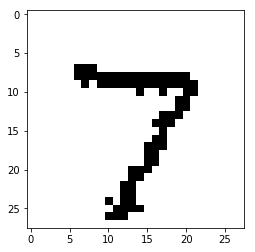

In [35]:
plt.imshow(mnist_data_test[0][0][0], cmap="binary")

# Load the GM VAE

In [114]:
def plot_prediction(idx):
    #idx = mnist_data_test[]
    prediction = Predictor.predict(model, mnist_data_test[idx][0])
    
    plt.axis('off')
    plt.imshow(mnist_data_test[idx][0].reshape(28,28))
    fig, axs = plt.subplots(2,prediction.shape[0]//2)#, figsize=(15, 15))
#    fig.subplots_adjust(hspace = .5, wspace=.001)
    
    for ax, d in zip(axs.ravel(), prediction):
        ax.imshow(d[0].reshape(28,28))
        ax.set_axis_off()
        #ax.set_title("Prediction")

In [37]:
from gmvae import GMVAE
from gmvae import NegVariationalLowerBound


##################################################
LAST TESTED SYSTEM ENVIRONMENT
0.4 (torch.__version__)
3.5 (ummon.version)
##################################################



In [97]:
model = GMVAE(mixtures_count=10)
ts = Trainingstate("MNIST_GMVAE_10_best_valid_loss")
ts.load_weights_(model, None)
ts.get_summary()

OrderedDict([('Epochs', 303),
             ('Best Training Loss', (193, 8491.128515625001, 100)),
             ('Best Validation Loss', (303, 8923.195180664059, 10000))])

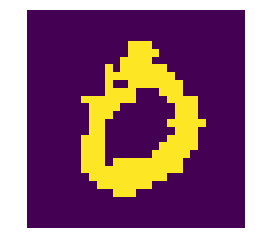

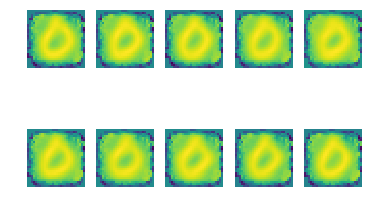

In [115]:
plot_prediction(3)

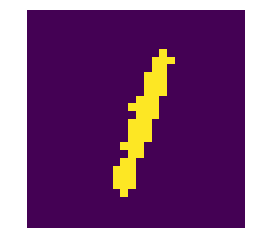

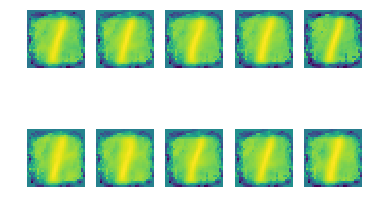

In [116]:
plot_prediction(5)

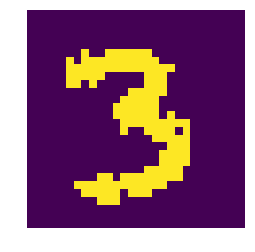

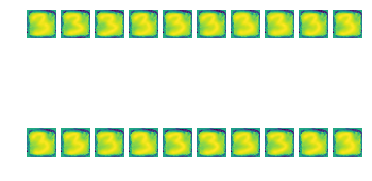

In [119]:
plot_prediction(500)

In [175]:
model = GMVAE(mixtures_count=10)
ts = Trainingstate("MNIST_GMVAE_10_best_valid_loss")
ts.load_weights_(model, None)
ts.get_summary()

OrderedDict([('Epochs', 303),
             ('Best Training Loss', (193, 8491.128515625001, 100)),
             ('Best Validation Loss', (303, 8923.195180664059, 10000))])

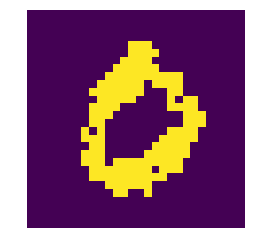

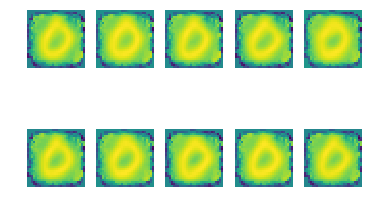

In [176]:
plot_prediction(3)

In [177]:
def z_prior(idx):
    return model.pz(model.y[0,idx])

In [178]:
zm_prior, zv_prior = z_prior(1)

In [179]:
def px(prior):
    zm_prior, zv_prior = prior
    return model.px(torch.distributions.Normal(zm_prior, zv_prior).sample().unsqueeze(0))

In [203]:
def sample_from_vae(prior = z_prior(1)):
    fig, axs = plt.subplots(10,10, figsize=(15, 15))
    fig.subplots_adjust(hspace = .05, wspace=.0)    
    for ax in axs.ravel():
        sample = px(prior).data.numpy()
        ax.imshow(sample.reshape(28,28))
        ax.set_axis_off()
    

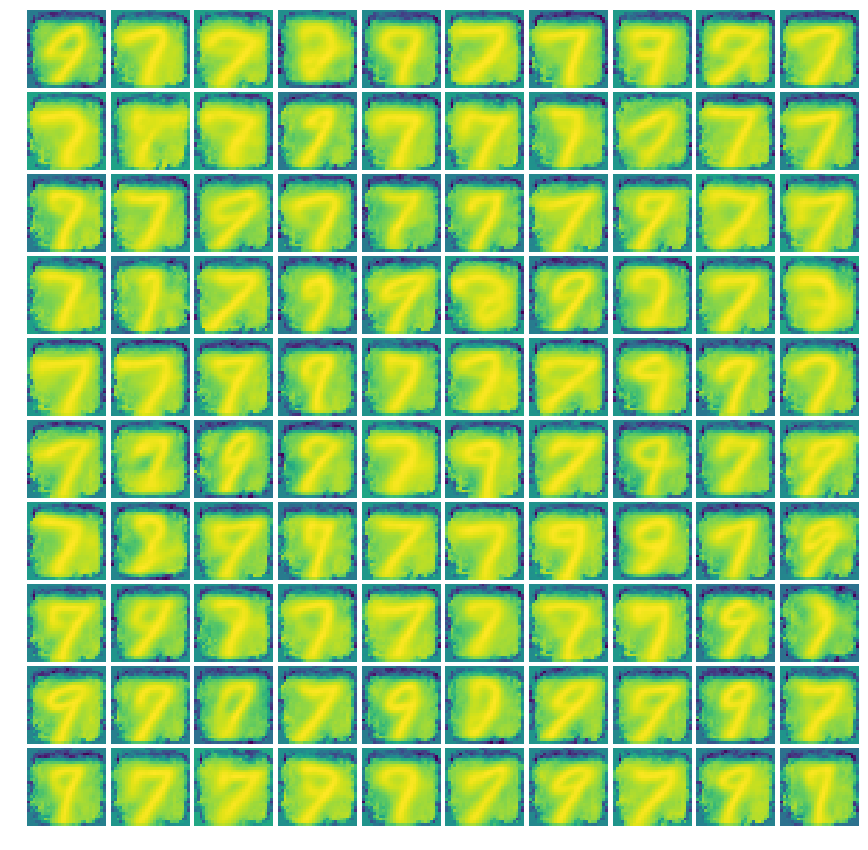

In [204]:
sample_from_vae(z_prior(1))

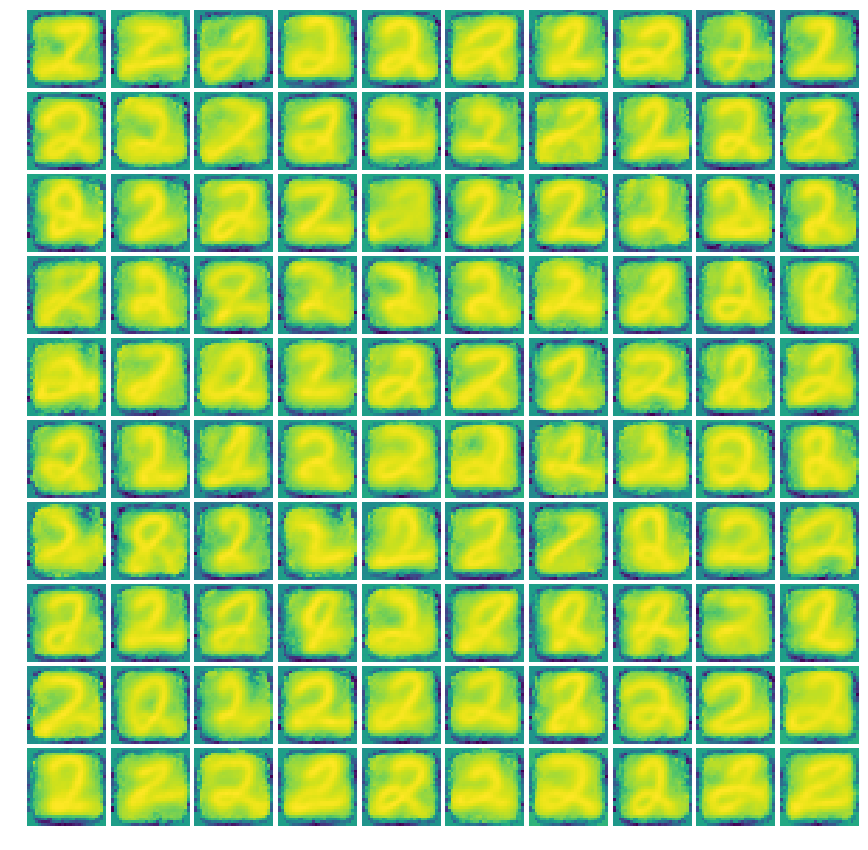

In [182]:
sample_from_vae(z_prior(2))

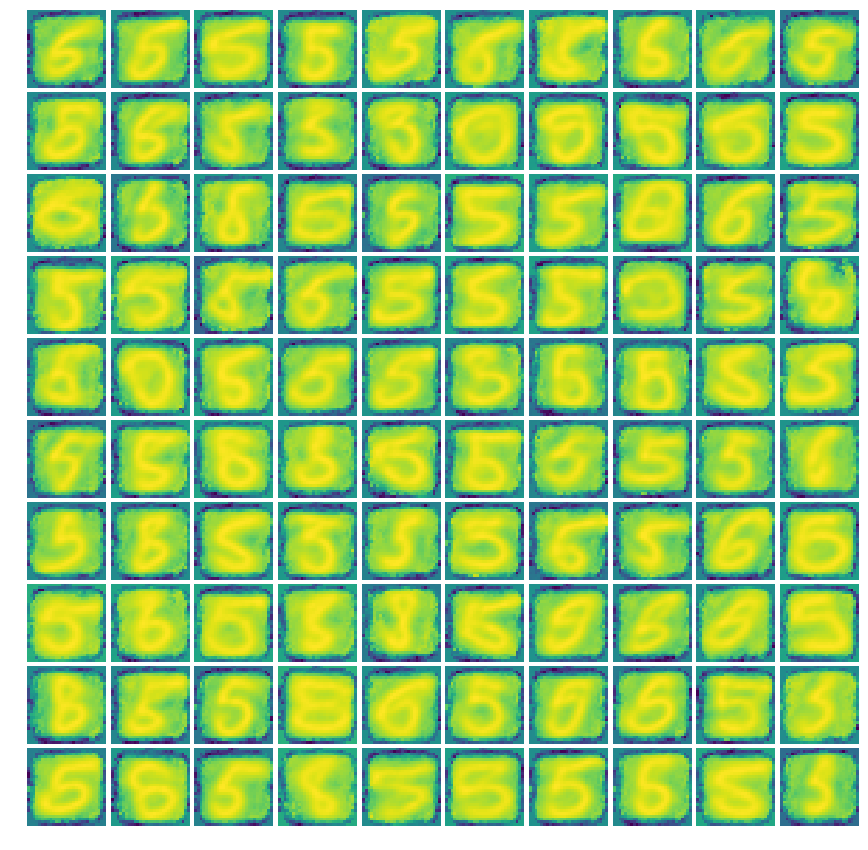

In [183]:
sample_from_vae(z_prior(3))

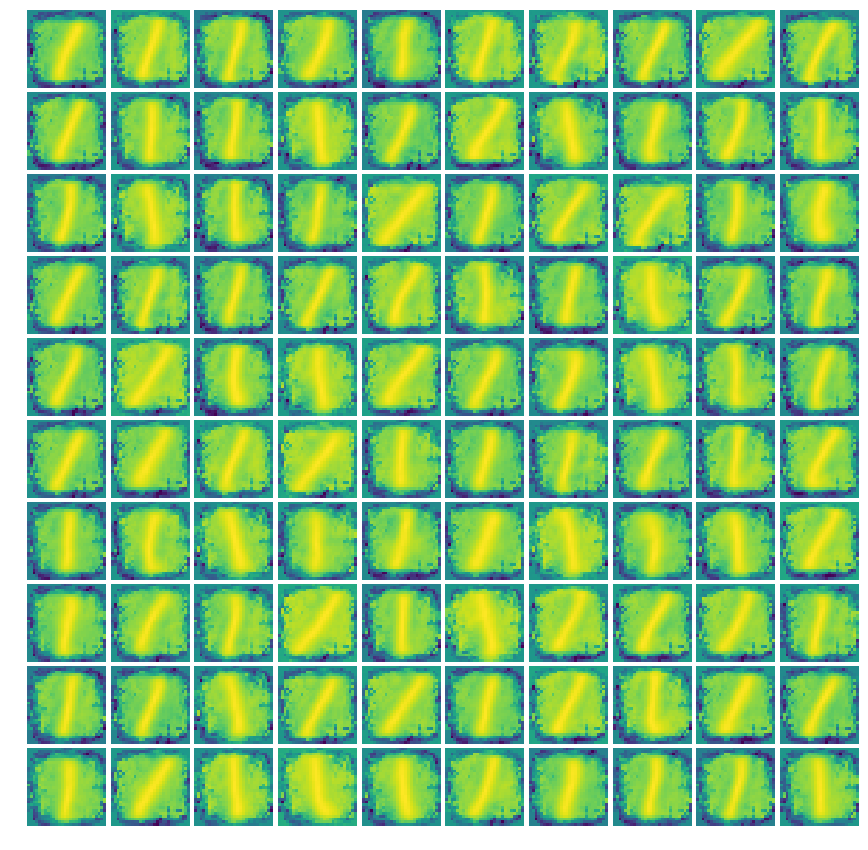

In [184]:
sample_from_vae(z_prior(4))

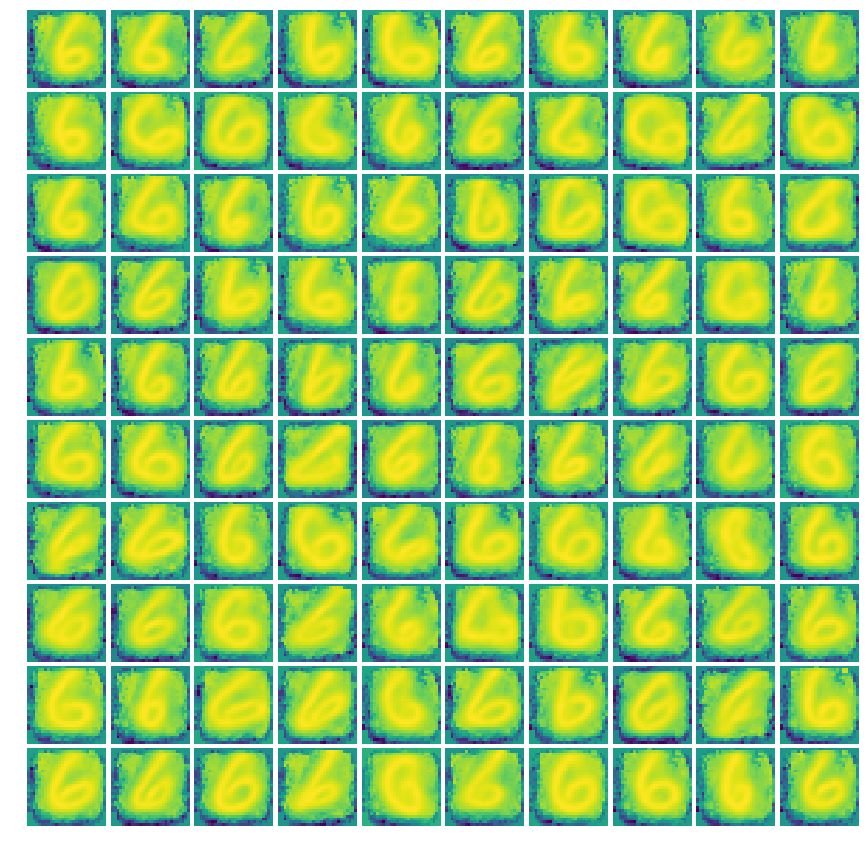

In [185]:
sample_from_vae(z_prior(5))

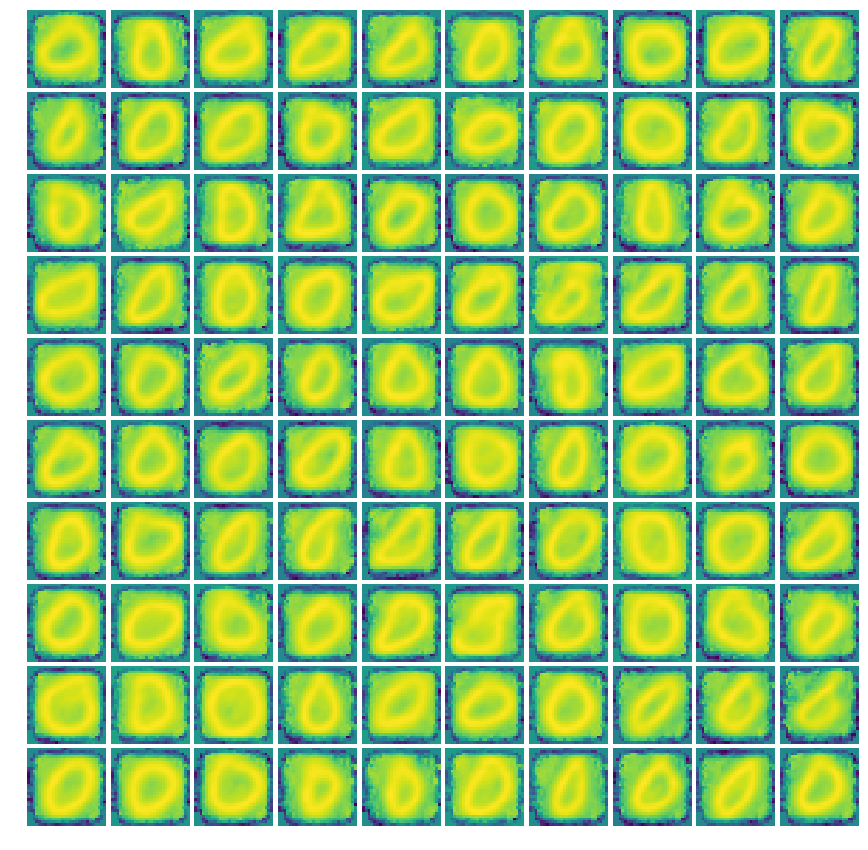

In [186]:
sample_from_vae(z_prior(6))

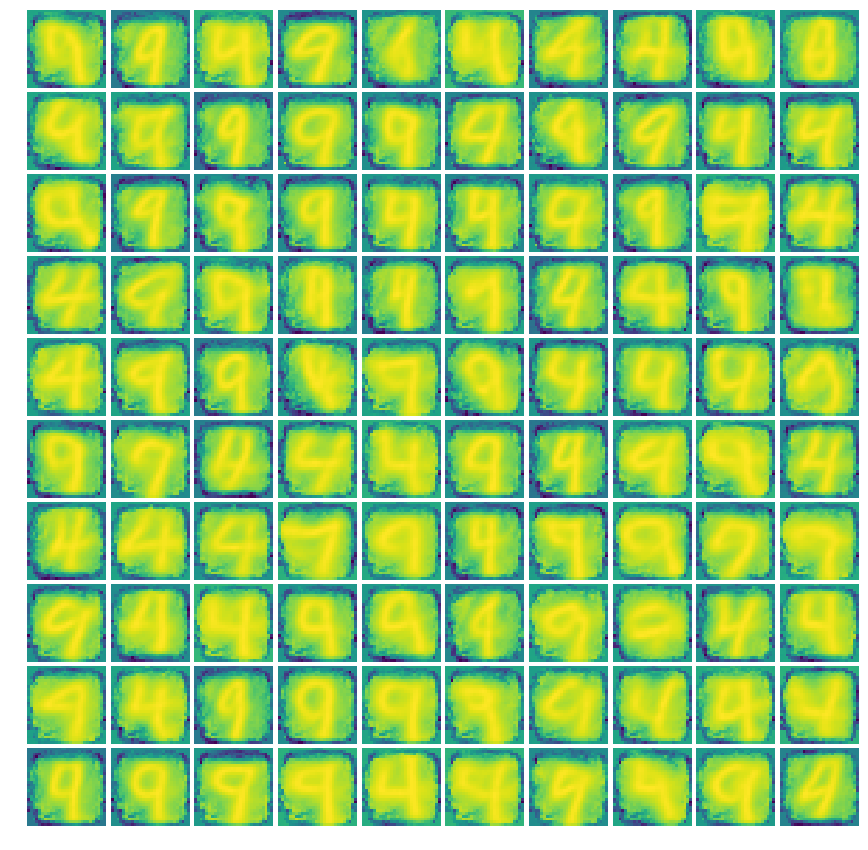

In [187]:
sample_from_vae(z_prior(7))

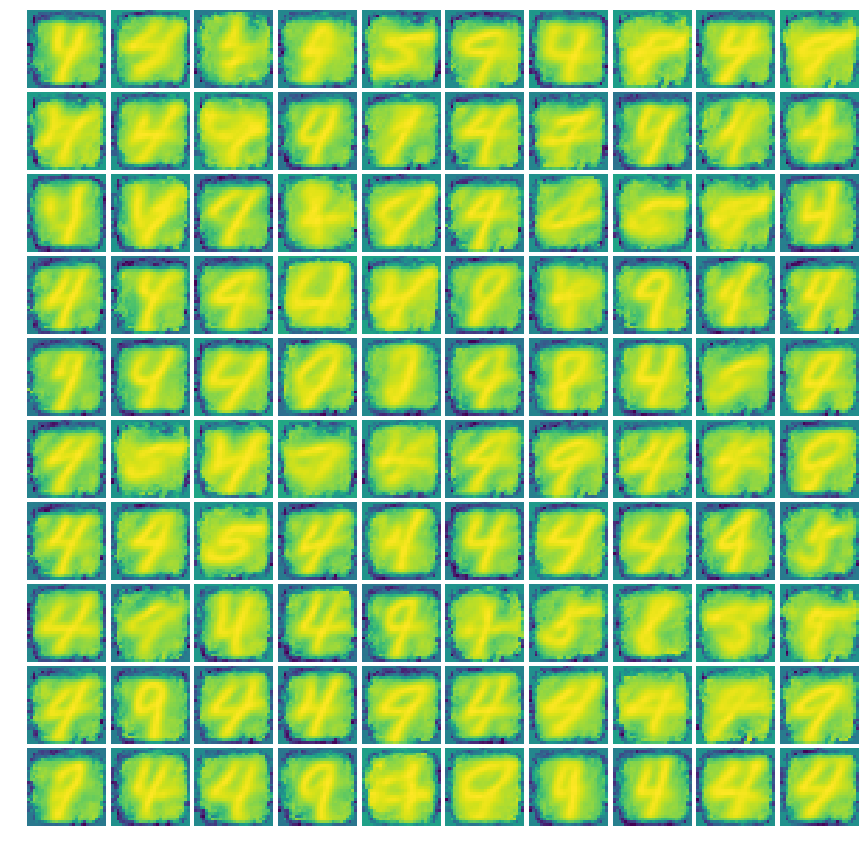

In [188]:
sample_from_vae(z_prior(8))

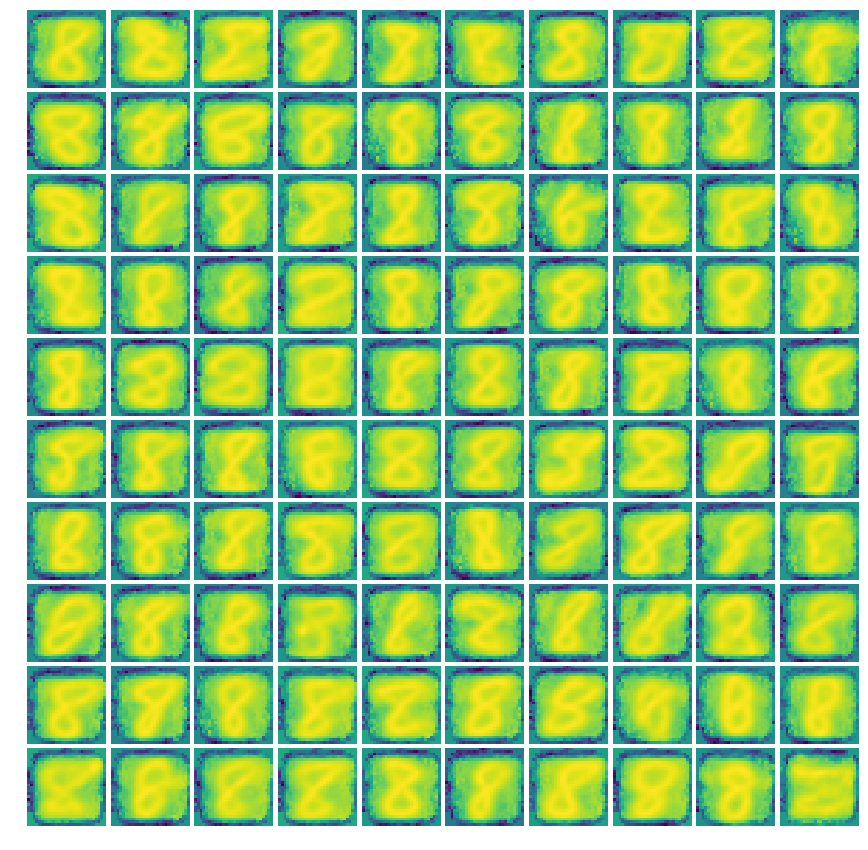

In [189]:
sample_from_vae(z_prior(9))

# Compactness Checks

In [264]:
data, labels = zip(*[(d[0],d[1].item()) for _, d in zip(range(1000), mnist_data_test)])
data = torch.cat(data).reshape(1000,-1).numpy()
labels = np.asarray(labels)

In [397]:
zeroes = data[labels == 0]
ones = data[labels == 1]
twos = data[labels == 2]
threes = data[labels == 3]
fours = data[labels == 4]
fives = data[labels == 5]
sixs = data[labels == 6]
two_and_threes = data[np.logical_or(labels == 2, labels == 3)]
four_five_sixs = data[np.logical_or(labels == 4, labels == 5, labels == 6)]

In [342]:
def predict_cluster(x):
    qy, _ = model.qy(x)
    return torch.max(qy, 1)[1]
        
def latent_repr(x, y):
    z, zm, zv = model.qz(x, y)
    return z

def compute_representation(numpy_samples):
    clusters = predict_cluster(torch.from_numpy(numpy_samples))
    codes = []
    for i, cluster_assignment in enumerate(clusters):
        x, y = torch.from_numpy(numpy_samples)[i], model.y[0, cluster_assignment]
        x, y = x.unsqueeze(0), y.unsqueeze(0)
        codes.append(latent_repr(x,y))
    codes_tensor = torch.cat(codes)
    return codes_tensor.data.numpy()

In [350]:
def compactness(numpy_samples):
    clusterd = numpy_samples
    cov = np.cov(clusterd.T)
    eig = np.linalg.eigvals(cov)
    plt.imshow(cov, cmap="gray")
    plt.show()
    plt.hist(eig)
    plt.show()

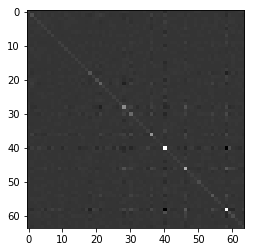

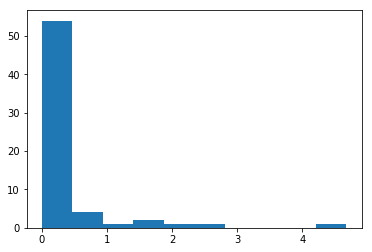

In [415]:
compactness(compute_representation(zeroes))

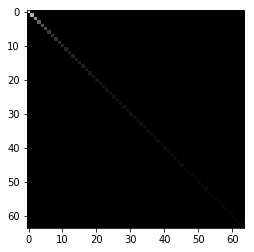

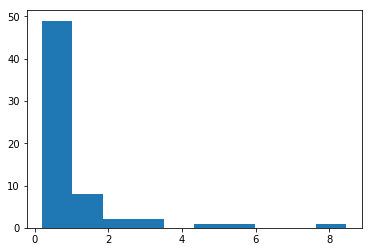

In [414]:
compactness(PCA(n_components=64).fit_transform(zeroes))

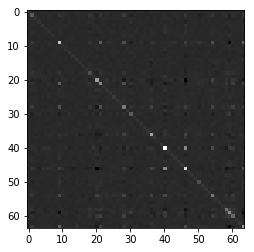

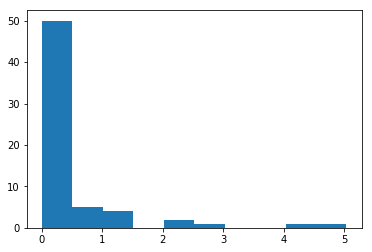

In [353]:
compactness(compute_representation(twos))

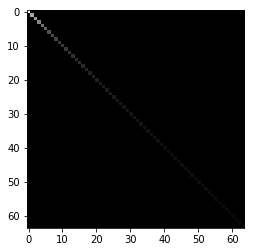

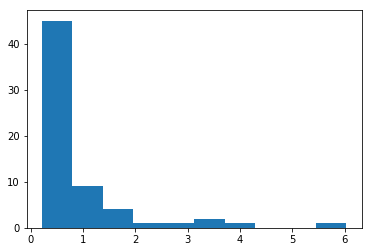

In [413]:
compactness(PCA(n_components=64).fit_transform(twos))

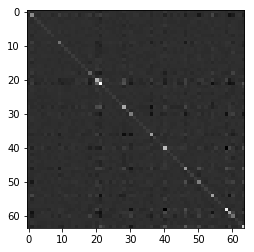

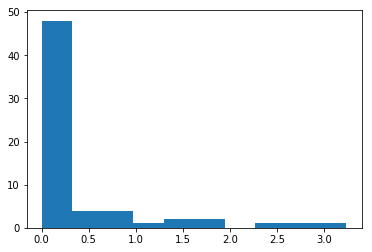

46958.61998480025

In [440]:
compactness(compute_representation(threes))
np.abs(squareform(pdist(compute_representation(threes).T, metric='euclidean'))).sum()

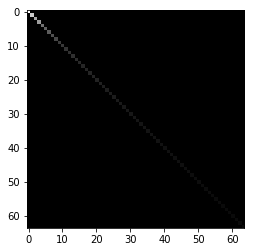

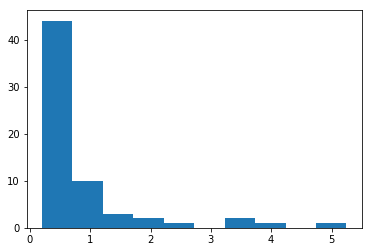

1946964.1559025766

In [457]:
threes_centered = threes - threes.mean(0)
compactness(PCA(n_components=64).fit_transform(threes_centered))
np.abs(squareform(pdist(threes_centered.T, metric='euclidean'))).sum()

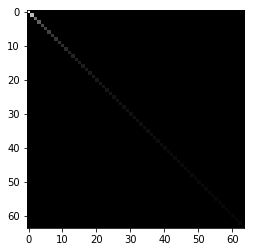

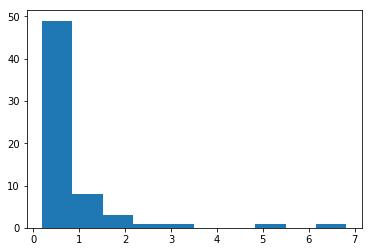

2854497.357527826

In [458]:
four_five_sixs_centered = four_five_sixs - four_five_sixs.mean(0)
compactness(PCA(n_components=64).fit_transform(four_five_sixs_centered))
np.abs(squareform(pdist(four_five_sixs_centered.T, metric='euclidean'))).sum()

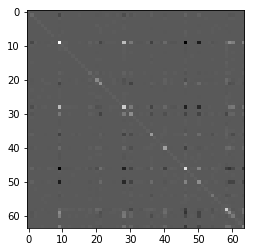

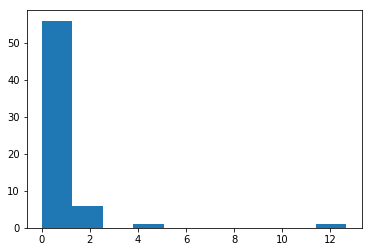

63756.52993024755

In [460]:
compactness(compute_representation(four_five_sixs))
np.abs(squareform(pdist(compute_representation(four_five_sixs).T, metric='euclidean'))).sum()

In [479]:
ll

total 671000
-rw-r--r-- 1 matthias     10095 May 25 17:46 1
-rw-r--r-- 1 matthias   3216084 Jun  4 16:45 Experiments.ipynb
-rw-r--r-- 1 matthias  42104386 Jun  1 05:22 MNIST_GMVAE_10_best_valid_loss.pth.tar
-rw-r--r-- 1 matthias  42137753 Jun  1 10:54 MNIST_GMVAE_12_best_valid_loss.pth.tar
-rw-r--r-- 1 matthias  42207591 May 30 19:50 MNIST_GMVAE_16_best_valid_loss.pth.tar
-rw-r--r-- 1 matthias  42320274 Jun  1 13:07 MNIST_GMVAE_20_best_valid_loss.pth.tar
-rw-r--r-- 1 matthias  42317821 Jun  1 12:57 MNIST_GMVAE_best_training_loss.pth.tar
drwxr-xr-x 2 matthias      4096 Jun  1 11:33 __pycache__/
-rw-r--r-- 1 matthias 471943642 Jun  4 16:45 cifar.npz
-rw-r--r-- 1 matthias     10473 Jun  4 13:38 gmvae.py
-rw-r--r-- 1 matthias      9862 May 29 16:06 m2.py
-rw-r--r-- 1 matthias    383326 Jun  4 16:45 mnist.npz
-rw------- 1 matthias    376682 Jun  1 13:23 nohup.out
drwxr-xr-x 2 matthias      4096 May 28 10:21 processed/
drwxr-xr-x 2 matthias      4096 May 28 10:20 raw/
-rw-r--r-- 1 matthias  

# Compactness checks data fabi

In [485]:
mnist_data_fabi = np.load("mnist.npz")
original, cae, labels = mnist_data_fabi["original"], mnist_data_fabi["cae"], mnist_data_fabi["labels"]

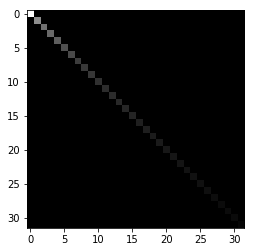

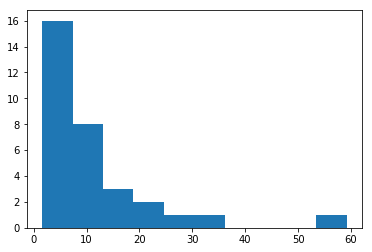

48584.49634927533

In [541]:
threes_fabi = cae[labels == 3]
threes_fabi_centered = threes_fabi - threes_fabi.mean(0)
compactness(PCA(n_components=32).fit_transform(threes_fabi_centered))
np.abs(squareform(pdist(threes_fabi_centered.T, metric='euclidean'))).sum()

In [568]:
cifar_data_fabi = np.load("local/cifar.npz")

In [569]:
original, cae, gram, labels = cifar_data_fabi["original"].reshape(1000,-1), cifar_data_fabi["cae"], cifar_data_fabi["gram"].reshape(1)[0]["pool4"].reshape(1000,-1), cifar_data_fabi["labels"]

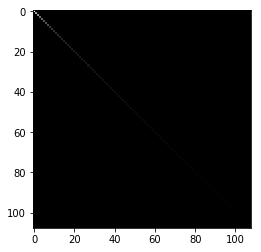

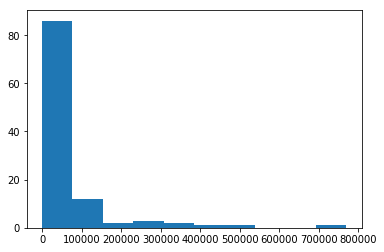

In [583]:
data = gram[labels == 3]
data = data - data.mean(0)
compactness(PCA(n_components=512).fit_transform(data))

#p.abs(squareform(pdist(data.T, metric='euclidean'))).sum()

(108, 262144)


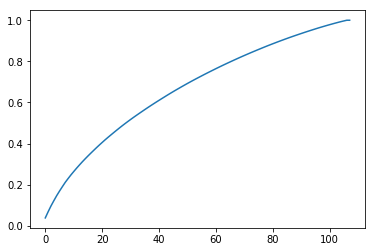

In [599]:
print(data.shape)
pca = PCA(n_components=512, svd_solver="full", tol=0.5).fit(data)
plt.plot(pca.singular_values_.cumsum()/pca.singular_values_.sum())

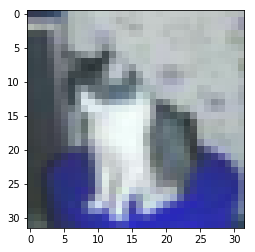

In [578]:

plt.imshow(original[labels == 3][0].reshape(3,32,32).transpose((1,2,0)))
#original[labels == 3][0].shape

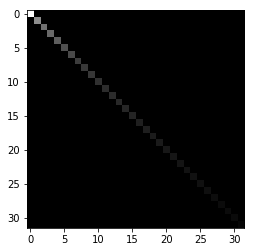

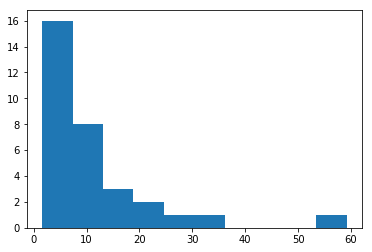

48584.49634927533

In [564]:
data = cae[labels == 3]
data = data - data.mean(0)
compactness(PCA(n_components=32).fit_transform(data))
np.abs(squareform(pdist(data.T, metric='euclidean'))).sum()

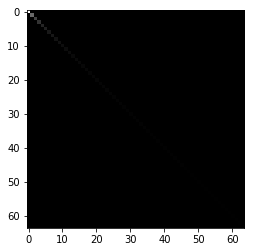

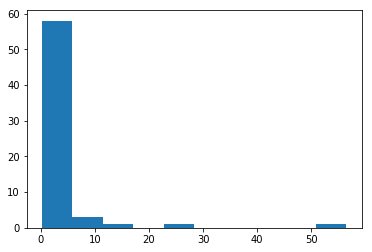

29420536.19293959

In [580]:
data = original[labels == 3]
data = data - data.mean(0)
compactness(PCA(n_components=64).fit_transform(data))
np.abs(squareform(pdist(data.T, metric='euclidean'))).sum()

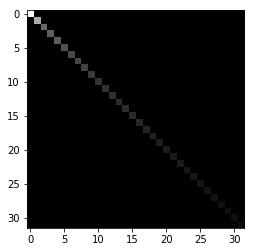

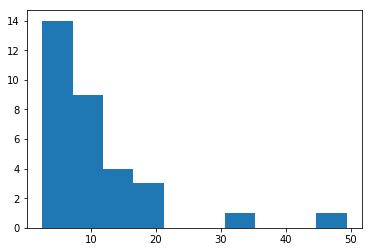

62983.0343887972

In [566]:
data = cae[np.logical_or(labels == 3, labels == 4)]
data = data - data.mean(0)
compactness(PCA(n_components=32).fit_transform(data))
np.abs(squareform(pdist(data.T, metric='euclidean'))).sum()